# ドテン君を全通貨ペアで検証

In [1]:
import datetime
from math import floor
import pprint
import schedule
from statistics import mean
from statistics import median
from statistics import StatisticsError
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.pricing as pricing
from oandapyV20.endpoints.pricing import PricingInfo
from oandapyV20.contrib.requests import (MarketOrderRequest, StopLossDetails)
import oandapyV20.endpoints.forexlabs as labs

sys.path.append('../')
from oandapyV21 import *

# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"

## BT

In [10]:
# バックテスト
def back_test(df, inst, fee, seed_money, K, ref=5, lot=1000, kly_rate='None', print_=True):
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    assets = seed_money
    tmp_i = 0
    lot_l = []
    l_or_s = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []

    # 実行
    for i in range(len(df) - 1):
        rate = df.iat[i, 5] # 当日の終値
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        range_ = round(df.iat[i, 3] - df.iat[i, 4], 3) # High - Low
        range_list.append(range_)
    
        if i > ref:
            least_m = round(mean(range_list[i-ref-1:i-1]) * K, 3)
            open_high = round(df.iat[i, 3] - df.iat[i, 2], 3) # High - Open
            open_low = round(df.iat[i, 2] - df.iat[i, 4], 3) # Open - Low

            # 上昇トレンドと判断しロング
            if least_m < open_high and open_low < open_high:
                if pos == 'entry_long':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_short':
                        exit_rate = next_rate
                        pips = (entry_rate - exit_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['short'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_long'
                    tmp_i = i
        
            # 下降トレンドと判断しショート
            if least_m < open_low and open_high < open_low:
                if pos == 'entry_short':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_long':
                        exit_rate = next_rate
                        pips = (exit_rate - entry_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['long'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_short'
                    tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'l_or_s': l_or_s, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

In [11]:
df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'H12', 'USD_JPY')

In [22]:
pos_df = back_test(df, '', fee=0.004, seed_money=3000000, K=0.5, ref=5, kly_rate=0.5, print_=True)

pos count:  1909, assets: 4673564円


In [23]:
get_evaluation(pos_df)

勝率: 41.80%
ペイオフレシオ: 1.7708
プロフィットファクター: 1.2529
期待値: 876.671円
最大ドローダウン: 302628.3円, 9.50%
ケリー基準: 8.94%


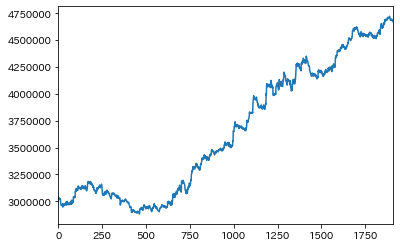

In [24]:
pos_df['assets'].plot()

In [25]:
pos_df

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
0,16107,long,2010-01-05 22:00:00+00:00,92.340,2010-01-07 22:00:00+00:00,93.127,78.3,12611.781,3012611.781
1,16475,short,2010-01-07 22:00:00+00:00,93.127,2010-01-12 22:00:00+00:00,91.428,169.5,27925.125,3040536.906
2,16667,long,2010-01-12 22:00:00+00:00,91.428,2010-01-14 10:00:00+00:00,91.213,-21.9,-3650.073,3036886.833
3,16660,short,2010-01-14 10:00:00+00:00,91.213,2010-01-19 10:00:00+00:00,91.140,6.9,1149.540,3038036.373
4,16699,long,2010-01-19 10:00:00+00:00,91.140,2010-01-19 22:00:00+00:00,90.960,-18.4,-3072.616,3034963.757
5,16633,short,2010-01-19 22:00:00+00:00,90.960,2010-01-20 10:00:00+00:00,91.231,-27.5,-4574.075,3030389.682
6,16753,long,2010-01-20 10:00:00+00:00,91.231,2010-01-21 10:00:00+00:00,90.439,-79.6,-13335.388,3017054.294
7,16715,short,2010-01-21 10:00:00+00:00,90.439,2010-01-24 10:00:00+00:00,90.248,18.7,3125.705,3020179.999
8,16732,long,2010-01-24 10:00:00+00:00,90.248,2010-01-24 22:00:00+00:00,90.248,-0.4,-66.928,3020113.071
9,16779,short,2010-01-24 22:00:00+00:00,90.248,2010-01-27 10:00:00+00:00,89.995,24.9,4177.971,3024291.042


### 通貨ペアと足と係数と参照本数の検証

In [12]:
# スプレッド取得
sp = {}
for inst in all_inst():
    sp[inst] = pip_spread(inst)[2]

In [ ]:
# 足検証
# inst_df = pd.DataFrame(columns=['instrument', 'K', 'gran', 'ref', 'pos_count', 'profit',
#                                 'WP(%)', 'POR', 'PF', 'E(円)', 'DD(pips)', 'KLY(%)'])
grans = ['M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
for inst in all_inst()[18:]:
    for gran in grans:
        df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran, inst)
        for k in range(5, 25+1):
            K = round(k * 0.1, 2)
            for ref in range(2, 9):
                inst_df = pd.read_csv('inst_df.csv')
                print('inst: {}, gran: {:>3}, K: {}, ref: {}, '.format(inst, gran, K, ref), end='')
                pos_df = back_test(df, inst, fee=sp[inst], seed_money=1000000, K=K, ref=ref, print_=False)
                pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
                WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
                print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
                tmp_se = pd.Series([inst, K, gran, ref, pos_count, profit, WP, POR, PF, E, DD, KLY], index=inst_df.columns)
                inst_df = inst_df.append(tmp_se, ignore_index=True)
                pos_df.to_csv('Instrument_pos_df/{:0>8}.csv'.format(inst_df.tail(1).index[0]), index=False)
                inst_df.to_csv('inst_df.csv', index=False)

inst: USD_SAR, gran:   D, K: 0.5, ref: 2, pos count:      143, profit:     -1.413
inst: USD_SAR, gran:   D, K: 0.5, ref: 3, pos count:      133, profit:     -1.306
inst: USD_SAR, gran:   D, K: 0.5, ref: 4, pos count:      131, profit:     -1.294
inst: USD_SAR, gran:   D, K: 0.5, ref: 5, pos count:      131, profit:     -1.297
inst: USD_SAR, gran:   D, K: 0.5, ref: 6, pos count:      131, profit:     -1.296
inst: USD_SAR, gran:   D, K: 0.5, ref: 7, pos count:      125, profit:     -1.237
inst: USD_SAR, gran:   D, K: 0.5, ref: 8, pos count:      125, profit:     -1.238
inst: USD_SAR, gran:   D, K: 0.6, ref: 2, pos count:       99, profit:     -0.993
inst: USD_SAR, gran:   D, K: 0.6, ref: 3, pos count:      103, profit:     -1.016
inst: USD_SAR, gran:   D, K: 0.6, ref: 4, pos count:      107, profit:     -1.049
inst: USD_SAR, gran:   D, K: 0.6, ref: 5, pos count:      117, profit:     -1.148
inst: USD_SAR, gran:   D, K: 0.6, ref: 6, pos count:      117, profit:     -1.156
inst: USD_SAR, g

inst: USD_SAR, gran:   D, K: 1.9, ref: 4, pos count:       47, profit:     -0.468
inst: USD_SAR, gran:   D, K: 1.9, ref: 5, pos count:       40, profit:     -0.399
inst: USD_SAR, gran:   D, K: 1.9, ref: 6, pos count:       41, profit:     -0.417
inst: USD_SAR, gran:   D, K: 1.9, ref: 7, pos count:       43, profit:     -0.438
inst: USD_SAR, gran:   D, K: 1.9, ref: 8, pos count:       51, profit:     -0.514
inst: USD_SAR, gran:   D, K: 2.0, ref: 2, pos count:       36, profit:     -0.366
inst: USD_SAR, gran:   D, K: 2.0, ref: 3, pos count:       32, profit:     -0.313
inst: USD_SAR, gran:   D, K: 2.0, ref: 4, pos count:       46, profit:     -0.458
inst: USD_SAR, gran:   D, K: 2.0, ref: 5, pos count:       40, profit:     -0.401
inst: USD_SAR, gran:   D, K: 2.0, ref: 6, pos count:       41, profit:     -0.417
inst: USD_SAR, gran:   D, K: 2.0, ref: 7, pos count:       41, profit:     -0.421
inst: USD_SAR, gran:   D, K: 2.0, ref: 8, pos count:       49, profit:     -0.491
inst: USD_SAR, g

inst: USD_SAR, gran: H12, K: 1.2, ref: 6, pos count:       95, profit:     -0.945
inst: USD_SAR, gran: H12, K: 1.2, ref: 7, pos count:       87, profit:     -0.864
inst: USD_SAR, gran: H12, K: 1.2, ref: 8, pos count:      102, profit:     -1.021
inst: USD_SAR, gran: H12, K: 1.3, ref: 2, pos count:       75, profit:     -0.755
inst: USD_SAR, gran: H12, K: 1.3, ref: 3, pos count:       87, profit:     -0.851
inst: USD_SAR, gran: H12, K: 1.3, ref: 4, pos count:       83, profit:     -0.828
inst: USD_SAR, gran: H12, K: 1.3, ref: 5, pos count:       71, profit:     -0.711
inst: USD_SAR, gran: H12, K: 1.3, ref: 6, pos count:       89, profit:     -0.892
inst: USD_SAR, gran: H12, K: 1.3, ref: 7, pos count:       85, profit:     -0.844
inst: USD_SAR, gran: H12, K: 1.3, ref: 8, pos count:      102, profit:     -1.018
inst: USD_SAR, gran: H12, K: 1.4, ref: 2, pos count:       75, profit:     -0.772
inst: USD_SAR, gran: H12, K: 1.4, ref: 3, pos count:       87, profit:     -0.851
inst: USD_SAR, g

inst: USD_SAR, gran:  H8, K: 0.5, ref: 8, pos count:      196, profit:     -1.973
inst: USD_SAR, gran:  H8, K: 0.6, ref: 2, pos count:      156, profit:     -1.560
inst: USD_SAR, gran:  H8, K: 0.6, ref: 3, pos count:      170, profit:     -1.726
inst: USD_SAR, gran:  H8, K: 0.6, ref: 4, pos count:      172, profit:     -1.736
inst: USD_SAR, gran:  H8, K: 0.6, ref: 5, pos count:      174, profit:     -1.752
inst: USD_SAR, gran:  H8, K: 0.6, ref: 6, pos count:      178, profit:     -1.794
inst: USD_SAR, gran:  H8, K: 0.6, ref: 7, pos count:      162, profit:     -1.625
inst: USD_SAR, gran:  H8, K: 0.6, ref: 8, pos count:      170, profit:     -1.701
inst: USD_SAR, gran:  H8, K: 0.7, ref: 2, pos count:      156, profit:     -1.565
inst: USD_SAR, gran:  H8, K: 0.7, ref: 3, pos count:      166, profit:     -1.667
inst: USD_SAR, gran:  H8, K: 0.7, ref: 4, pos count:      144, profit:     -1.438
inst: USD_SAR, gran:  H8, K: 0.7, ref: 5, pos count:      150, profit:     -1.502
inst: USD_SAR, g

inst: USD_SAR, gran:  H8, K: 2.0, ref: 3, pos count:       71, profit:     -0.741
inst: USD_SAR, gran:  H8, K: 2.0, ref: 4, pos count:       92, profit:     -0.950
inst: USD_SAR, gran:  H8, K: 2.0, ref: 5, pos count:       82, profit:     -0.851
inst: USD_SAR, gran:  H8, K: 2.0, ref: 6, pos count:       78, profit:     -0.819
inst: USD_SAR, gran:  H8, K: 2.0, ref: 7, pos count:       72, profit:     -0.742
inst: USD_SAR, gran:  H8, K: 2.0, ref: 8, pos count:       88, profit:     -0.883
inst: USD_SAR, gran:  H8, K: 2.1, ref: 2, pos count:       81, profit:     -0.810
inst: USD_SAR, gran:  H8, K: 2.1, ref: 3, pos count:       71, profit:     -0.741
inst: USD_SAR, gran:  H8, K: 2.1, ref: 4, pos count:       59, profit:     -0.621
inst: USD_SAR, gran:  H8, K: 2.1, ref: 5, pos count:       82, profit:     -0.868
inst: USD_SAR, gran:  H8, K: 2.1, ref: 6, pos count:       72, profit:     -0.755
inst: USD_SAR, gran:  H8, K: 2.1, ref: 7, pos count:       68, profit:     -0.693
inst: USD_SAR, g

inst: USD_SAR, gran:  H6, K: 1.3, ref: 5, pos count:      131, profit:     -1.322
inst: USD_SAR, gran:  H6, K: 1.3, ref: 6, pos count:      139, profit:     -1.396
inst: USD_SAR, gran:  H6, K: 1.3, ref: 7, pos count:      131, profit:     -1.311
inst: USD_SAR, gran:  H6, K: 1.3, ref: 8, pos count:      145, profit:     -1.450
inst: USD_SAR, gran:  H6, K: 1.4, ref: 2, pos count:      125, profit:     -1.272
inst: USD_SAR, gran:  H6, K: 1.4, ref: 3, pos count:      155, profit:     -1.560
inst: USD_SAR, gran:  H6, K: 1.4, ref: 4, pos count:      133, profit:     -1.336
inst: USD_SAR, gran:  H6, K: 1.4, ref: 5, pos count:      129, profit:     -1.300
inst: USD_SAR, gran:  H6, K: 1.4, ref: 6, pos count:      139, profit:     -1.396
inst: USD_SAR, gran:  H6, K: 1.4, ref: 7, pos count:      125, profit:     -1.244
inst: USD_SAR, gran:  H6, K: 1.4, ref: 8, pos count:      121, profit:     -1.206
inst: USD_SAR, gran:  H6, K: 1.5, ref: 2, pos count:      117, profit:     -1.199
inst: USD_SAR, g

inst: USD_SAR, gran:  H4, K: 0.6, ref: 7, pos count:      262, profit:     -2.671
inst: USD_SAR, gran:  H4, K: 0.6, ref: 8, pos count:      264, profit:     -2.695
inst: USD_SAR, gran:  H4, K: 0.7, ref: 2, pos count:      238, profit:     -2.436
inst: USD_SAR, gran:  H4, K: 0.7, ref: 3, pos count:      260, profit:     -2.635
inst: USD_SAR, gran:  H4, K: 0.7, ref: 4, pos count:      222, profit:     -2.254
inst: USD_SAR, gran:  H4, K: 0.7, ref: 5, pos count:      240, profit:     -2.433
inst: USD_SAR, gran:  H4, K: 0.7, ref: 6, pos count:      250, profit:     -2.543
inst: USD_SAR, gran:  H4, K: 0.7, ref: 7, pos count:      262, profit:     -2.676
inst: USD_SAR, gran:  H4, K: 0.7, ref: 8, pos count:      240, profit:     -2.438
inst: USD_SAR, gran:  H4, K: 0.8, ref: 2, pos count:      236, profit:     -2.431
inst: USD_SAR, gran:  H4, K: 0.8, ref: 3, pos count:      194, profit:     -1.997
inst: USD_SAR, gran:  H4, K: 0.8, ref: 4, pos count:      220, profit:     -2.232
inst: USD_SAR, g

inst: USD_SAR, gran:  H4, K: 2.1, ref: 2, pos count:      138, profit:     -1.422
inst: USD_SAR, gran:  H4, K: 2.1, ref: 3, pos count:      120, profit:     -1.232
inst: USD_SAR, gran:  H4, K: 2.1, ref: 4, pos count:       96, profit:     -0.985
inst: USD_SAR, gran:  H4, K: 2.1, ref: 5, pos count:      128, profit:     -1.305
inst: USD_SAR, gran:  H4, K: 2.1, ref: 6, pos count:      115, profit:     -1.193
inst: USD_SAR, gran:  H4, K: 2.1, ref: 7, pos count:      109, profit:     -1.142
inst: USD_SAR, gran:  H4, K: 2.1, ref: 8, pos count:      103, profit:     -1.070
inst: USD_SAR, gran:  H4, K: 2.2, ref: 2, pos count:      138, profit:     -1.422
inst: USD_SAR, gran:  H4, K: 2.2, ref: 3, pos count:      120, profit:     -1.232
inst: USD_SAR, gran:  H4, K: 2.2, ref: 4, pos count:       96, profit:     -0.985
inst: USD_SAR, gran:  H4, K: 2.2, ref: 5, pos count:      128, profit:     -1.305
inst: USD_SAR, gran:  H4, K: 2.2, ref: 6, pos count:      115, profit:     -1.189
inst: USD_SAR, g

inst: USD_SAR, gran:  H3, K: 1.4, ref: 4, pos count:      180, profit:     -1.822
inst: USD_SAR, gran:  H3, K: 1.4, ref: 5, pos count:      144, profit:     -1.437
inst: USD_SAR, gran:  H3, K: 1.4, ref: 6, pos count:      178, profit:     -1.791
inst: USD_SAR, gran:  H3, K: 1.4, ref: 7, pos count:      156, profit:     -1.559
inst: USD_SAR, gran:  H3, K: 1.4, ref: 8, pos count:      142, profit:     -1.416
inst: USD_SAR, gran:  H3, K: 1.5, ref: 2, pos count:      144, profit:     -1.440
inst: USD_SAR, gran:  H3, K: 1.5, ref: 3, pos count:      208, profit:     -2.094
inst: USD_SAR, gran:  H3, K: 1.5, ref: 4, pos count:      172, profit:     -1.747
inst: USD_SAR, gran:  H3, K: 1.5, ref: 5, pos count:      144, profit:     -1.443
inst: USD_SAR, gran:  H3, K: 1.5, ref: 6, pos count:      174, profit:     -1.749
inst: USD_SAR, gran:  H3, K: 1.5, ref: 7, pos count:      152, profit:     -1.514
inst: USD_SAR, gran:  H3, K: 1.5, ref: 8, pos count:      142, profit:     -1.417
inst: USD_SAR, g

inst: USD_SAR, gran:  H2, K: 0.7, ref: 6, pos count:      308, profit:     -3.117
inst: USD_SAR, gran:  H2, K: 0.7, ref: 7, pos count:      320, profit:     -3.236
inst: USD_SAR, gran:  H2, K: 0.7, ref: 8, pos count:      302, profit:     -3.062
inst: USD_SAR, gran:  H2, K: 0.8, ref: 2, pos count:      288, profit:     -2.902
inst: USD_SAR, gran:  H2, K: 0.8, ref: 3, pos count:      262, profit:     -2.633
inst: USD_SAR, gran:  H2, K: 0.8, ref: 4, pos count:      290, profit:     -2.926
inst: USD_SAR, gran:  H2, K: 0.8, ref: 5, pos count:      298, profit:     -3.017
inst: USD_SAR, gran:  H2, K: 0.8, ref: 6, pos count:      282, profit:     -2.856
inst: USD_SAR, gran:  H2, K: 0.8, ref: 7, pos count:      290, profit:     -2.930
inst: USD_SAR, gran:  H2, K: 0.8, ref: 8, pos count:      302, profit:     -3.067
inst: USD_SAR, gran:  H2, K: 0.9, ref: 2, pos count:      286, profit:     -2.883
inst: USD_SAR, gran:  H2, K: 0.9, ref: 3, pos count:      262, profit:     -2.635
inst: USD_SAR, g

inst: USD_SAR, gran:  H2, K: 2.1, ref: 8, pos count:      156, profit:     -1.565
inst: USD_SAR, gran:  H2, K: 2.2, ref: 2, pos count:      196, profit:     -1.972
inst: USD_SAR, gran:  H2, K: 2.2, ref: 3, pos count:      164, profit:     -1.659
inst: USD_SAR, gran:  H2, K: 2.2, ref: 4, pos count:      152, profit:     -1.542
inst: USD_SAR, gran:  H2, K: 2.2, ref: 5, pos count:      202, profit:     -2.044
inst: USD_SAR, gran:  H2, K: 2.2, ref: 6, pos count:      182, profit:     -1.840
inst: USD_SAR, gran:  H2, K: 2.2, ref: 7, pos count:      168, profit:     -1.690
inst: USD_SAR, gran:  H2, K: 2.2, ref: 8, pos count:      156, profit:     -1.565
inst: USD_SAR, gran:  H2, K: 2.3, ref: 2, pos count:      196, profit:     -1.972
inst: USD_SAR, gran:  H2, K: 2.3, ref: 3, pos count:      152, profit:     -1.534
inst: USD_SAR, gran:  H2, K: 2.3, ref: 4, pos count:      152, profit:     -1.542
inst: USD_SAR, gran:  H2, K: 2.3, ref: 5, pos count:      202, profit:     -2.044
inst: USD_SAR, g

inst: USD_SAR, gran:  H1, K: 1.5, ref: 3, pos count:      308, profit:     -3.145
inst: USD_SAR, gran:  H1, K: 1.5, ref: 4, pos count:      286, profit:     -2.923
inst: USD_SAR, gran:  H1, K: 1.5, ref: 5, pos count:      264, profit:     -2.704
inst: USD_SAR, gran:  H1, K: 1.5, ref: 6, pos count:      292, profit:     -2.975
inst: USD_SAR, gran:  H1, K: 1.5, ref: 7, pos count:      282, profit:     -2.883
inst: USD_SAR, gran:  H1, K: 1.5, ref: 8, pos count:      270, profit:     -2.769
inst: USD_SAR, gran:  H1, K: 1.6, ref: 2, pos count:      236, profit:     -2.426
inst: USD_SAR, gran:  H1, K: 1.6, ref: 3, pos count:      214, profit:     -2.209
inst: USD_SAR, gran:  H1, K: 1.6, ref: 4, pos count:      286, profit:     -2.923
inst: USD_SAR, gran:  H1, K: 1.6, ref: 5, pos count:      264, profit:     -2.704
inst: USD_SAR, gran:  H1, K: 1.6, ref: 6, pos count:      248, profit:     -2.529
inst: USD_SAR, gran:  H1, K: 1.6, ref: 7, pos count:      282, profit:     -2.883
inst: USD_SAR, g

inst: USD_SAR, gran: M30, K: 0.8, ref: 5, pos count:      412, profit:     -4.223
inst: USD_SAR, gran: M30, K: 0.8, ref: 6, pos count:      402, profit:     -4.117
inst: USD_SAR, gran: M30, K: 0.8, ref: 7, pos count:      412, profit:     -4.227
inst: USD_SAR, gran: M30, K: 0.8, ref: 8, pos count:      422, profit:     -4.324
inst: USD_SAR, gran: M30, K: 0.9, ref: 2, pos count:      384, profit:     -3.937
inst: USD_SAR, gran: M30, K: 0.9, ref: 3, pos count:      362, profit:     -3.716
inst: USD_SAR, gran: M30, K: 0.9, ref: 4, pos count:      386, profit:     -3.947
inst: USD_SAR, gran: M30, K: 0.9, ref: 5, pos count:      372, profit:     -3.815
inst: USD_SAR, gran: M30, K: 0.9, ref: 6, pos count:      402, profit:     -4.117
inst: USD_SAR, gran: M30, K: 0.9, ref: 7, pos count:      384, profit:     -3.923
inst: USD_SAR, gran: M30, K: 0.9, ref: 8, pos count:      400, profit:     -4.107
inst: USD_SAR, gran: M30, K: 1.0, ref: 2, pos count:      380, profit:     -3.882
inst: USD_SAR, g

limit_output extension: Maximum message size of 100000 exceeded with 100040 characters

In [91]:
# pd.DataFrame(data=sp.items(), columns=['instrument', 'spread']).to_csv('spreads.csv', index=False)
# sp = pd.read_csv('spreads.csv').to_dict()

In [2]:
inst_df = pd.read_csv('inst_df.csv')
# inst_df.to_csv('inst_df.csv', index=False)
inst_df.head()

,instrument,K,gran,ref,pos_count,profit,WP(%),POR,PF,E(円),DD(%),KLY(%)
0,USD_ZAR,0.5,D,2,1005,-10.67732,36.72,1.4581,0.8460,-10.624,1.76,-6.68
1,USD_ZAR,0.5,D,3,1009,-8.09871,37.26,1.4855,0.8824,-8.026,1.73,-4.97
2,USD_ZAR,0.5,D,4,1031,-9.51642,37.05,1.4706,0.8656,-9.230,2.07,-5.75
3,USD_ZAR,0.5,D,5,1028,-9.59991,36.58,1.4975,0.8636,-9.338,1.56,-5.78
4,USD_ZAR,0.5,D,6,1025,-7.96498,36.88,1.5135,0.8842,-7.771,1.66,-4.83


In [3]:
inst_df.sort_values(by='profit', ascending=False).head(50)

,instrument,K,gran,ref,pos_count,profit,WP(%),POR,PF,E(円),DD(%),KLY(%)
75453,GBP_JPY,1.0,H8,8,1006,226.014,42.94,1.9535,1.4702,224.666,1.39,13.73
75480,GBP_JPY,1.4,H8,7,481,212.696,46.15,1.9364,1.6598,442.195,2.12,18.35
75459,GBP_JPY,1.1,H8,7,838,210.550,43.44,1.9228,1.4766,251.253,1.92,14.02
75473,GBP_JPY,1.3,H8,7,586,203.198,43.52,2.0168,1.5537,346.754,1.66,15.51
75466,GBP_JPY,1.2,H8,7,700,202.452,44.00,1.9177,1.5067,289.217,1.68,14.80
75452,GBP_JPY,1.0,H8,7,1060,201.786,42.08,1.9383,1.4080,190.364,1.56,12.19
75465,GBP_JPY,1.2,H8,6,694,200.038,42.65,2.0056,1.4916,288.239,1.63,14.06
75460,GBP_JPY,1.1,H8,8,834,199.816,43.88,1.8458,1.4435,239.588,1.84,13.48
75472,GBP_JPY,1.3,H8,6,590,196.404,43.05,2.0025,1.5138,332.888,2.15,14.61
75481,GBP_JPY,1.4,H8,8,467,192.652,44.97,1.9642,1.6050,412.531,1.85,16.95


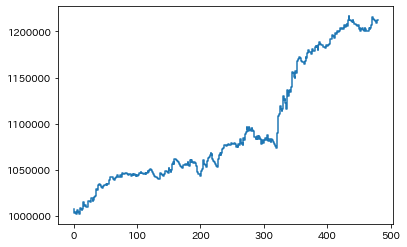

In [10]:
pos_df = pd.read_csv('Instrument_pos_df/{:0>8}.csv'.format(75480))
plt.plot(pos_df['assets'], ds='steps')
plt.show()

In [63]:
def plot_post(df, pos_df):
    en_l = list(map(str, pos_df['entry_date'].to_list()))
    ex_l = list(map(str, pos_df['exit_date'].to_list()))
    long_i = []
    long_l = []
    short_i = []
    short_l = []
    for i in range(len(df)):
        time = str(df.iat[i, 0])
        # get entry marker
        if time in en_l:
            j = en_l.index(time)
            if pos_df.iat[j, 1] == 'long':
                long_l.extend([pos_df.iat[j, 3]])
                long_i.extend([i])
            else:
                short_l.extend([pos_df.iat[j, 3]])
                short_i.extend([i])
        # get exit marker
        if time in ex_l:
            j = ex_l.index(time)
            if pos_df.iat[j, 1] == 'long':
                short_l.extend([pos_df.iat[j, 5]])
                short_i.extend([i])
            else:
                long_l.extend([pos_df.iat[j, 5]])
                long_i.extend([i])
    fig = create_candlestick(open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])
    fig.add_scatter(x=long_i, y=long_l, name='long', mode='markers', marker={
        "size": 10,
        "symbol": 'triangle-up',
        'color': '#00e1ff'
    })
    fig.add_scatter(x=short_i, y=short_l, name='short', mode='markers', marker={
        "size": 10,
        "symbol": 'triangle-down',
        'color': '#ffee00'
    })
    fig.show()

In [64]:
gran = 'H8'
inst = 'GBP_JPY'
# df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran, inst)
fig = plot_post(df, pos_df)

In [5]:
inst_df[inst_df['instrument']=='USD_JPY'].sort_values(by='profit', ascending=False).head(20)

,instrument,K,gran,ref,pos_count,profit,WP(%),POR,PF,E(円),DD(%),KLY(%)
47485,USD_JPY,0.5,H12,5,1909,99.126,41.80,1.7708,1.2719,51.926,1.56,8.94
47486,USD_JPY,0.5,H12,6,1917,96.181,41.73,1.7609,1.2611,50.173,1.50,8.64
47487,USD_JPY,0.5,H12,7,1919,94.026,41.06,1.8028,1.2561,48.997,1.98,8.37
47490,USD_JPY,0.6,H12,3,1622,90.992,41.31,1.8089,1.2731,56.099,1.15,8.86
48136,USD_JPY,1.4,H3,5,1382,88.031,42.33,1.7475,1.2827,63.698,1.27,9.33
47488,USD_JPY,0.5,H12,8,1919,86.334,40.59,1.8031,1.2321,44.989,2.23,7.65
47483,USD_JPY,0.5,H12,3,1940,83.692,40.62,1.7906,1.2248,43.140,1.45,7.46
48137,USD_JPY,1.4,H3,6,1360,82.666,42.79,1.6930,1.2665,60.784,1.85,9.00
47645,USD_JPY,0.7,H8,4,1964,81.942,41.24,1.7383,1.2201,41.722,1.28,7.44
47648,USD_JPY,0.7,H8,7,1935,81.606,42.17,1.6711,1.2186,42.174,1.30,7.57


In [312]:
# df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'H12', 'GBP_JPY')
pos_df = back_test(df, 'GBP_JPY', fee=0.014, seed_money=1000000, K=1.1, ref=4, kly_rate=0.5, print_=False)

In [308]:
inst = 'GBP_JPY'
pip_spread(inst, print_=True), sp[inst]

0.01JPY = 1pips, spread: 1.4pips, 0.013999999999999999JPY


(None, 0.014)

In [313]:
get_evaluation(pos_df)

勝率: 44.67%
ペイオフレシオ: 1.8762
プロフィットファクター: 1.5180
期待値: 1544.267円
最大ドローダウン: 149484.7円, 9.47%
ケリー基準: 15.18%


In [314]:
pos_df.tail(1)

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
590,6640,short,2019-12-13 10:00:00+00:00,145.808,2019-12-25 22:00:00+00:00,142.219,357.5,23738.0,1912661.551


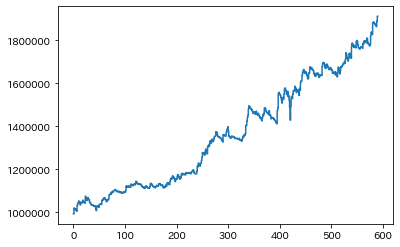

In [315]:
plt.plot(pos_df['assets'], ds='steps')
plt.show()

In [7]:
inst_df[inst_df['instrument']=='EUR_JPY'].sort_values(by='profit', ascending=False).head(20)

,instrument,K,gran,ref,pos_count,profit,WP(%),POR,PF,E(円),DD(%),KLY(%)
8919,EUR_JPY,1.9,H3,3,836,171.569,46.41,1.7909,1.5510,205.226,2.47,16.49
8926,EUR_JPY,2.0,H3,3,746,153.597,45.31,1.8215,1.5090,205.894,2.66,15.28
8913,EUR_JPY,1.8,H3,4,891,149.149,44.44,1.7829,1.4263,167.395,3.33,13.28
8912,EUR_JPY,1.8,H3,3,958,140.501,45.51,1.6618,1.3880,146.661,3.61,12.72
8921,EUR_JPY,1.9,H3,5,732,134.310,44.13,1.7933,1.4163,183.484,2.75,12.97
8928,EUR_JPY,2.0,H3,5,638,131.686,43.10,1.9172,1.4524,206.404,2.37,13.43
8899,EUR_JPY,1.6,H3,4,1209,127.654,42.02,1.7962,1.3017,105.586,2.53,9.74
8947,EUR_JPY,2.3,H3,3,532,126.493,44.36,1.8798,1.4988,237.769,1.95,14.76
8776,EUR_JPY,1.9,H4,7,440,124.836,44.32,1.9685,1.5668,283.718,2.70,16.03
8238,EUR_JPY,0.5,H12,8,1964,123.805,41.96,1.6942,1.2246,63.037,1.14,7.69


In [322]:
inst_df.shape

(97609, 12)

### df + pos_df

In [94]:
df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'H12', 'GBP_JPY')

In [98]:
df.head(50)

,Time,Volume,Open,High,Low,Close
0,2009-12-31 22:00:00+00:00,5,150.345,150.373,150.337,150.373
1,2010-01-03 10:00:00+00:00,1032,150.358,150.361,149.769,149.814
2,2010-01-03 22:00:00+00:00,46714,149.810,150.458,149.087,150.391
3,2010-01-04 10:00:00+00:00,47832,150.387,150.721,148.663,148.793
4,2010-01-04 22:00:00+00:00,47987,148.791,149.158,147.360,147.486
5,2010-01-05 10:00:00+00:00,55048,147.484,147.572,146.146,146.652
6,2010-01-05 22:00:00+00:00,48185,146.654,148.130,146.004,147.956
7,2010-01-06 10:00:00+00:00,54658,147.958,148.462,147.056,147.881
8,2010-01-06 22:00:00+00:00,46722,147.879,148.298,147.068,147.997
9,2010-01-07 10:00:00+00:00,56251,147.995,148.774,147.796,148.750


In [97]:
pos_df.head()

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
0,1000,short,2010-01-05 10:00:00+00:00,146.654,2010-01-12 22:00:00+00:00,148.494,-185.4,-1854.0,998146.0
1,1000,long,2010-01-12 22:00:00+00:00,148.494,2010-01-19 22:00:00+00:00,148.288,-22.0,-220.0,997926.0
2,1000,short,2010-01-19 22:00:00+00:00,148.288,2010-02-04 22:00:00+00:00,140.493,778.1,7781.0,1005707.0
3,1000,long,2010-02-04 22:00:00+00:00,140.493,2010-02-05 10:00:00+00:00,139.783,-72.4,-724.0,1004983.0
4,1000,short,2010-02-05 10:00:00+00:00,139.783,2010-02-09 10:00:00+00:00,140.987,-121.8,-1218.0,1003765.0


In [ ]:
# バックテスト
def back_test(df, inst, fee, seed_money, K, ref=5, lot=1000, kly_rate='None', print_=True):
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    assets = seed_money
    tmp_i = 0
    lot_l = []
    l_or_s = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []

    # 実行
    for i in range(len(df) - 1):
        rate = df.iat[i, 5] # 当日の終値
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        range_ = round(df.iat[i, 3] - df.iat[i, 4], 3) # High - Low
        range_list.append(range_)
    
        if i > ref:
            least_m = round(mean(range_list[i-ref-1:i-1]) * K, 3)
            open_high = round(df.iat[i, 3] - df.iat[i, 2], 3) # High - Open
            open_low = round(df.iat[i, 2] - df.iat[i, 4], 3) # Open - Low

            # 上昇トレンドと判断しロング
            if least_m < open_high and open_low < open_high:
                if pos == 'entry_long':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_short':
                        exit_rate = next_rate
                        pips = (entry_rate - exit_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = math.floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['short'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_long'
                    tmp_i = i
        
            # 下降トレンドと判断しショート
            if least_m < open_low and open_high < open_low:
                if pos == 'entry_short':
                    continue
                else:
                    # もし逆のポジションを持ってたら利確
                    if pos == 'entry_long':
                        exit_rate = next_rate
                        pips = (exit_rate - entry_rate - fee) * 100
                        if kly_rate != 'None':
                            kly = assets * kly_rate
                            lot = math.floor(kly / exit_rate)
                        profit = pips * lot / 100
                        assets = round(assets + profit, 4)
                        lot_l.extend([lot])
                        l_or_s.extend(['long'])
                        entry_date.extend([df.iat[tmp_i, 0]])
                        entry_rate_l.extend([entry_rate])
                        exit_date.extend([df.iat[i, 0]])
                        exit_rate_l.extend([exit_rate])
                        pips_l.extend([pips])
                        profit_l.extend([profit])
                        assets_l.extend([assets])
                        if assets < 0:
                            break
                    entry_rate = next_rate
                    pos = 'entry_short'
                    tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'l_or_s': l_or_s, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df, df_pos_df

In [101]:
pos_df.head()

,lot,l_or_s,entry_date,entry_rate,exit_date,exit_rate,pips,profit,assets
0,1000,short,2010-01-05 10:00:00+00:00,146.654,2010-01-12 22:00:00+00:00,148.494,-185.4,-1854.0,998146.0
1,1000,long,2010-01-12 22:00:00+00:00,148.494,2010-01-19 22:00:00+00:00,148.288,-22.0,-220.0,997926.0
2,1000,short,2010-01-19 22:00:00+00:00,148.288,2010-02-04 22:00:00+00:00,140.493,778.1,7781.0,1005707.0
3,1000,long,2010-02-04 22:00:00+00:00,140.493,2010-02-05 10:00:00+00:00,139.783,-72.4,-724.0,1004983.0
4,1000,short,2010-02-05 10:00:00+00:00,139.783,2010-02-09 10:00:00+00:00,140.987,-121.8,-1218.0,1003765.0
